# Notebook 2: MLP model

In [ ]:
#When running this code on colabratory, put this boolean to True. Else, put it to False
colabratory = True

if colabratory == True:
  #allow access to files
  from google.colab import drive
  drive.mount('/content/gdrive')

  #install missing packages
  !pip install aidapy
  !pip install h5netcdf
  !pip install optuna

  #travel to correct directory
  %cd gdrive/MyDrive/Univeristy/version_180521/

In [1]:
%run notebook_setup.py

In [2]:
import optuna

## Data

In [3]:
ml_method = 'mlp'
data_version = 'mms1_samp_4dot5s' 
data_process = 'no_flux_shuffle' #_znorm' 
period = '2016_2018'

x_train, y_train, x_test, y_test, x_val, y_val = l_tools.generate_train_test(
    ml_method, 
    data_version, 
    data_process, 
    period)

In [17]:
print(association)

{0: 'sw', 1: 'fs', 2: 'bs', 3: 'msh', 4: 'mp', 5: 'bl', 6: 'msp', 7: 'ps', 8: 'psbl', 9: 'lobe'}


Convert y data to categorical:

In [4]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat  = keras.utils.to_categorical(y_test)
y_val_cat   = keras.utils.to_categorical(y_val)


print('>> TRAINING DATASET \t',
      x_train.shape,'\t\t',
      y_train.shape,'\t',
      y_train_cat.shape)
print('>> VALIDATION DATASET \t',
      x_val.shape,'\t\t',
      y_val.shape,'\t',
      y_val_cat.shape)
print('>> TEST DATASET \t',
      x_test.shape,'\t\t',
      y_test.shape,'\t',
      y_test_cat.shape)

>> TRAINING DATASET 	 (748761, 12) 		 (748761,) 	 (748761, 10)
>> VALIDATION DATASET 	 (249588, 12) 		 (249588,) 	 (249588, 10)
>> TEST DATASET 	 (332784, 12) 		 (332784,) 	 (332784, 10)


Check for nans:

In [5]:
print("Do train sets have Nans?")
print("X: " + str(np.any(np.isnan(x_train))))
print("Y: " + str(np.any(np.isnan(y_train))))
print("Y-cat: " + str(np.any(np.isnan(y_train_cat))))
print("Do validation sets have Nans?")
print("X: " + str(np.any(np.isnan(x_val))))
print("Y: " + str(np.any(np.isnan(y_val))))
print("Y-cat: " + str(np.any(np.isnan(y_val_cat))))
print("Do test sets have Nans?")
print("X: " + str(np.any(np.isnan(x_test))))
print("Y: " + str(np.any(np.isnan(y_test))))
print("Y-cat: " + str(np.any(np.isnan(y_test_cat))))

Do train sets have Nans?
X: False
Y: False
Y-cat: False
Do validation sets have Nans?
X: False
Y: False
Y-cat: False
Do test sets have Nans?
X: False
Y: False
Y-cat: False


Plot histograms of data:

(array([21277., 47619., 21156., 41481., 33369., 44303., 46353., 35432.,
        26645., 15149.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


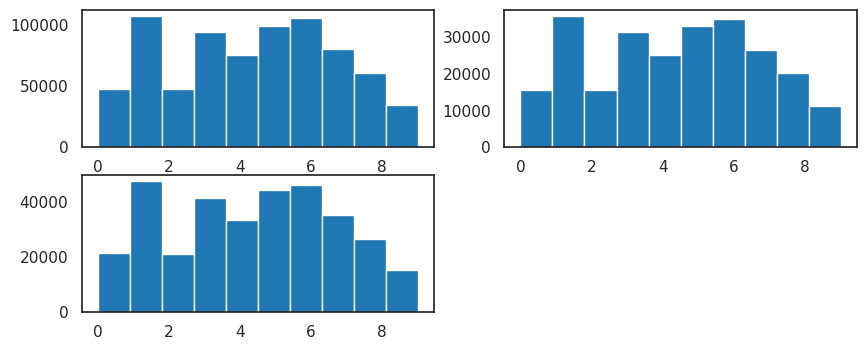

In [6]:
#histograms for y train/val/test
plt.figure(num=1, figsize=(10,4))

plt.subplot(221)
plt.hist(y_train)
plt.subplot(222)
plt.hist(y_val)
plt.subplot(223)
plt.hist(y_test)

Check mins and maxes:

In [7]:
#min and max of datasets
np.min(x_train), np.max(x_train), \
np.min(x_val),   np.max(x_val), \
np.min(x_test),  np.max(x_test),\
np.min(y_train_cat), np.max(y_train_cat), \
np.min(y_val_cat),   np.max(y_val_cat), \
np.min(y_test_cat),  np.max(y_test_cat)

(-1039.3299560546875,
 15719.703125,
 -980.8472900390625,
 14417.646484375,
 -950.3854370117188,
 14518.9609375,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0)

## Load stored example model

In [7]:
example_model = keras.models.load_model('./trained_model/mlp/trained_model.hdf5')
example_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1664      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1

In [20]:
#example_model.layers[1].rate, example_model.layers[4].rate, example_model.layers[7].rate
example_model.layers[2].activation, example_model.layers[5].activation, example_model.layers[8].activation

(<function tensorflow.python.keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0)>,
 <function tensorflow.python.keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0)>,
 <function tensorflow.python.keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0)>)

## 1 - reproduce MLP model locally

#using sequential
model = None
inputshape = (12,)
drop_frac = 0.01


model = keras.Sequential()

model.add(layers.Dense(128,input_shape=inputshape))
model.add(layers.Dropout(rate=drop_frac))
model.add(tf.keras.layers.Activation('relu'))  

model.add(layers.Dense(128))
model.add(layers.Dropout(rate=drop_frac))
model.add(tf.keras.layers.Activation('relu')) 

model.add(layers.Dense(128))
model.add(layers.Dropout(rate=drop_frac))
model.add(tf.keras.layers.Activation('relu'))   

model.add(layers.Dense(10))
model.add(tf.keras.layers.Activation('relu'))  

model.summary()

In [41]:
#not using sequential
model = None
inputshape = (12,)

## Parameters
drop_frac = 0.01
nb_layers = 3
batch_norm = True
n_units = 128
m_activation = 'relu'


## Architecture
inputs = keras.Input(shape=inputshape)

x_layer = inputs
for i in range(nb_layers):
    x_layer  = layers.Dense(n_units)(x_layer) 
    
    if batch_norm:
        x_layer  = layers.BatchNormalization() (x_layer)
    
    if drop_frac>0.:
        x_layer  = layers.Dropout(drop_frac)(x_layer)
    
    x_layer = layers.Activation(m_activation) (x_layer)

outputs = layers.Dense(10, activation = 'softmax')(x_layer)

## Model
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1664      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512 

### Use Optuna to make a model with hyperparameter optimisation

In [5]:
def get_data(x_train,y_train_cat,x_val,y_val_cat):
    train_ds = (x_train,y_train_cat)
    valid_ds = (x_val, y_val_cat)
    return train_ds, valid_ds

In [6]:
def create_model(trial):
    opt_model = None
    inputshape = (12,)

    ## Parameters
    drop_frac = trial.suggest_float('drop_frac',0, 0.1)
    n_layers = trial.suggest_int('n_layers', 1, 5)
    batch_norm = True
    m_activation = trial.suggest_categorical("activation", ["relu"]) # should i add more here?
    
    ## Architecture
    inputs = keras.Input(shape=inputshape)

    x_layer = inputs
    for i in range(n_layers):
        n_units = int(trial.suggest_loguniform('n_units_l{}'.format(i), 4, 128)) # moved into for-loop
        x_layer  = layers.Dense(n_units)(x_layer) 
    
        if batch_norm:
            x_layer  = layers.BatchNormalization() (x_layer)
    
        if drop_frac>0.:
            x_layer  = layers.Dropout(drop_frac)(x_layer)
    
        x_layer = layers.Activation(m_activation) (x_layer)

    outputs = layers.Dense(10, activation = 'softmax')(x_layer)

    ## Model
    opt_model = keras.Model(inputs=inputs, outputs=outputs)   
    
    return opt_model

In [7]:
def create_optimizer(trial):
    kwargs = {}
    optimizer_options = ["Adam"]
    optimizer_selected = trial.suggest_categorical("opt", optimizer_options)
    if optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    opt = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return opt

In [30]:
def learn(model, optimizer, dataset, mode="eval"):
    accuracy = tf.metrics.Accuracy("accuracy", dtype=tf.float32)
    #batch
    #features = dataset[0]
    #labels = dataset[1]
    print(dataset)
        
    for batch, (features, labels) in enumerate(dataset):
        with tf.GradientTape() as tape:
            logits = model(features, training=(mode == "train"))
            loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    if mode == "eval":
        return accuracy

In [13]:
def objective(trial):
    #run settings
    nepochs   = 100
    # Get train/valid data.
    train_ds, valid_ds = get_data(x_train,y_train_cat,x_val,y_val_cat)

    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    # Training and validating cycle.
    for _ in range(100):
        learn(model, optimizer, train_ds, "train")

    accuracy = learn(model, optimizer, valid_ds, "eval")

    # Return last validation accuracy.
    return accuracy.result()

In [14]:
def search():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [29]:
search()

[I 2021-05-18 13:46:47,495] A new study created in memory with name: no-name-dd86e925-116a-43de-aab7-60d05607dfdd
[W 2021-05-18 13:46:47,573] Trial 0 failed because of the following error: ValueError('too many values to unpack (expected 2)')
Traceback (most recent call last):
  File "/home/lukas/anaconda3/envs/SW/lib/python3.7/site-packages/optuna/_optimize.py", line 217, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-13-ae9179e287ae>", line 13, in objective
    learn(model, optimizer, train_ds, "train")
  File "<ipython-input-28-32b26f3e9c6f>", line 8, in learn
    for batch, [features, labels] in enumerate(dataset):
ValueError: too many values to unpack (expected 2)


(array([[-1.08363848e+01,  3.68866324e+00,  5.46841955e+00, ...,
         5.91620300e+02,  6.27930298e+02,  6.09775269e+02],
       [-3.48536634e+00, -6.94923258e+00,  6.72221222e+01, ...,
         6.31955200e+02,  8.49751282e+02,  7.40853271e+02],
       [ 6.89898014e+00, -5.59817314e+00, -1.93511546e+00, ...,
         1.71987061e+02,  1.10736176e+02,  1.41361618e+02],
       ...,
       [-2.17098713e+01, -1.74964070e+00,  3.70327148e+01, ...,
         2.60175073e+03,  4.52209424e+03,  3.56192236e+03],
       [-6.52292728e+00,  6.85349035e+00,  3.54812126e+01, ...,
         7.64260938e+03,  9.62474609e+03,  8.63367773e+03],
       [ 1.72640324e+00, -1.94509482e+00,  1.45512354e+00, ...,
         3.83845306e+02,  1.49396378e+02,  2.66620850e+02]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], 

ValueError: too many values to unpack (expected 2)

### Load existing custom model

In [8]:
saved_model = keras.models.load_model('./results/mlp_run_28-04-2021_batchnorm_dropfrac/model.h5')
saved_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1664      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512 

## 2- Compile MLP model

Compile model using Adam optimizer , categorical crossentropy loss function and loss,accuracy metrics

In [9]:
#loss = 'categorical_crossentropy'
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
lr = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [10]:
use_existing == True
#compile saved model
if use_existing == True:
    saved_model.compile(optimizer=opt,
                        loss=loss,
                        metrics= ['accuracy'])
else:
    #compile new model
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics= ['accuracy'])

## 3 -  Train MLP model

Train model:

In [44]:
import datetime

m_dateformat = '%d-%m-%Y'
m_date = datetime.datetime.now().strftime(m_dateformat)
model_run_name = 'mlp_run_'+m_date

if batch_norm:
    model_run_name+='_batchnorm'
    
if drop_frac:
    model_run_name+='_dropfrac'
    
print(model_run_name)

log_dir = './results/' + model_run_name
if os.path.exists(log_dir)==False:
    os.makedirs(log_dir)


weights_path = os.path.join(log_dir, 'weights.h5')
model_path   = os.path.join(log_dir, 'model.h5')
history_path = os.path.join(log_dir, 'history.h5')

mlp_run_28-04-2021_batchnorm_dropfrac


In [45]:
#run settings
nepochs   = 100
batchsize = 64
patience  = 20 

In [46]:
callbacks = [TensorBoard(log_dir=log_dir,write_graph=True),
             #
             CSVLogger(os.path.join(log_dir,'training.csv')),
             #
             EarlyStopping(patience=patience), 
             #
             ModelCheckpoint(weights_path, 
                             save_weights_only = True, 
                             save_best_only = True, 
                             verbose = False),
]

callbacks

In [47]:
history = model.fit(x = x_train, 
                    y = y_train_cat, 
                    validation_data = (x_val, y_val_cat),
                    #
                    batch_size = batchsize, 
                    epochs = nepochs, 
                    #
                    callbacks = callbacks,
                    verbose = 2
                    #shuffle=True,
                    )

model.save(model_path)



Epoch 1/100
11700/11700 - 20s - loss: 0.7766 - accuracy: 0.7142 - val_loss: 0.6304 - val_accuracy: 0.7646
Epoch 2/100
11700/11700 - 20s - loss: 0.6337 - accuracy: 0.7662 - val_loss: 0.6068 - val_accuracy: 0.7710
Epoch 3/100
11700/11700 - 21s - loss: 0.5920 - accuracy: 0.7801 - val_loss: 0.5211 - val_accuracy: 0.8084
Epoch 4/100
11700/11700 - 21s - loss: 0.5656 - accuracy: 0.7903 - val_loss: 0.5186 - val_accuracy: 0.8058
Epoch 5/100
11700/11700 - 24s - loss: 0.5465 - accuracy: 0.7973 - val_loss: 0.4965 - val_accuracy: 0.8110
Epoch 6/100
11700/11700 - 22s - loss: 0.5319 - accuracy: 0.8027 - val_loss: 0.4782 - val_accuracy: 0.8213
Epoch 7/100
11700/11700 - 23s - loss: 0.5201 - accuracy: 0.8077 - val_loss: 0.4627 - val_accuracy: 0.8304
Epoch 8/100
11700/11700 - 22s - loss: 0.5086 - accuracy: 0.8118 - val_loss: 0.4543 - val_accuracy: 0.8332
Epoch 9/100
11700/11700 - 21s - loss: 0.5002 - accuracy: 0.8145 - val_loss: 0.4532 - val_accuracy: 0.8266
Epoch 10/100
11700/11700 - 22s - loss: 0.4932 

Epoch 78/100
11700/11700 - 21s - loss: 0.3793 - accuracy: 0.8599 - val_loss: 0.3833 - val_accuracy: 0.8509
Epoch 79/100
11700/11700 - 21s - loss: 0.3794 - accuracy: 0.8602 - val_loss: 0.3810 - val_accuracy: 0.8520
Epoch 80/100
11700/11700 - 21s - loss: 0.3784 - accuracy: 0.8606 - val_loss: 0.3675 - val_accuracy: 0.8607
Epoch 81/100
11700/11700 - 21s - loss: 0.3785 - accuracy: 0.8605 - val_loss: 0.3608 - val_accuracy: 0.8642
Epoch 82/100
11700/11700 - 21s - loss: 0.3774 - accuracy: 0.8613 - val_loss: 0.3734 - val_accuracy: 0.8562
Epoch 83/100
11700/11700 - 21s - loss: 0.3774 - accuracy: 0.8608 - val_loss: 0.3743 - val_accuracy: 0.8551
Epoch 84/100
11700/11700 - 21s - loss: 0.3766 - accuracy: 0.8612 - val_loss: 0.3752 - val_accuracy: 0.8552
Epoch 85/100
11700/11700 - 21s - loss: 0.3760 - accuracy: 0.8614 - val_loss: 0.3796 - val_accuracy: 0.8545


## Display loss & accuracy

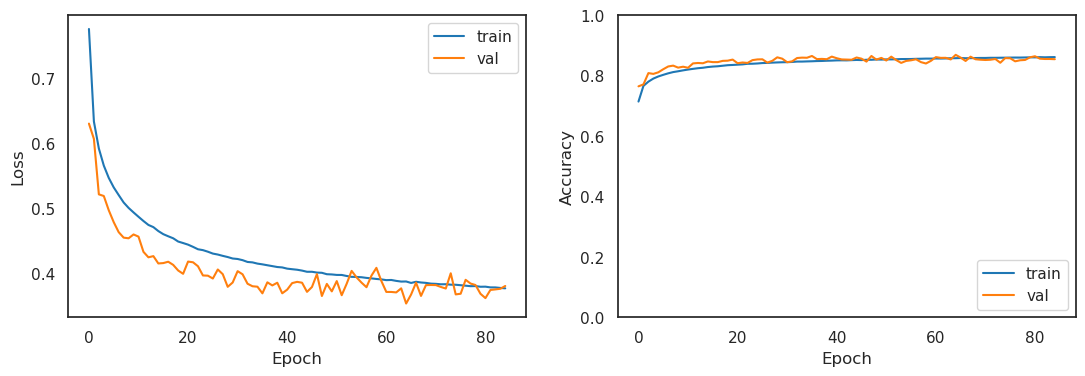

In [48]:
plt.close('all')
plt.figure(num=1, figsize=(13, 4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.grid('on')


plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0.0, 1.0)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.grid('on')

In [70]:
"""
# to open tensorboard, on terminal pinpoint to the result folder for the current runs:
    tensorboard --logdir=./results/

#On web browser:
    http://localhost:6006/
"""

'\n# to open tensorboard, on terminal pinpoint to the result folder for the current runs:\n    tensorboard --logdir=./results/\n\n#On web browser:\n    http://localhost:6006/\n'

## Display Confusion matrices

In [13]:
def convert_from_categorical(y_categorical):
    y_categorical = y_categorical / np.sum(y_categorical, axis=1).reshape((-1,1))
    y = np.argmax(y_categorical, axis=1)
    #edited to also return the score (Lukas)
    return y, y_categorical

#y_pred_cat = model.predict(x_test)
# or saved: 
y_pred_cat = saved_model.predict(x_test)


#edited to also assign the score (Lukas)
y_pred,y_score = convert_from_categorical(y_pred_cat)

In [14]:
cf_matrix_cnt = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=m_classnames_id)

temporary_vector = cf_matrix_cnt.sum(axis=1).astype("float"); 
temporary_vector[temporary_vector==0]=np.nan
cf_matrix = cf_matrix_cnt.astype("float")/temporary_vector[:,np.newaxis]


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
/home/lukas/Documents/Spaceweather/project/code/version_280421_LV/notebook_setup.py:190: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(formattedList)


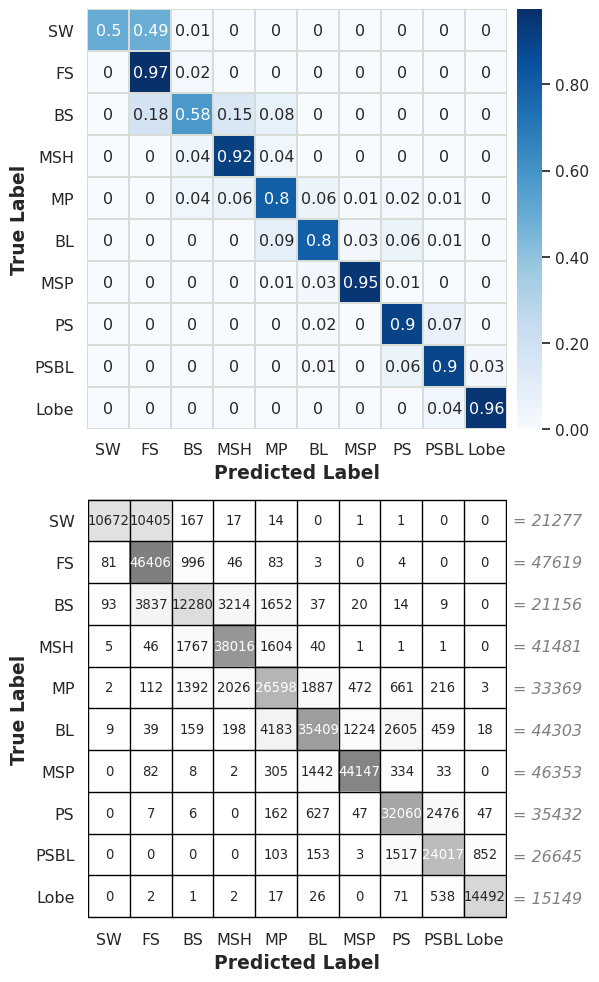

In [15]:
plt.close('all')
plot_conf_mat(cf_matrix_cnt, cf_matrix, m_classnames, txt_size=11.5)
#manual save required

## Display individual histograms

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

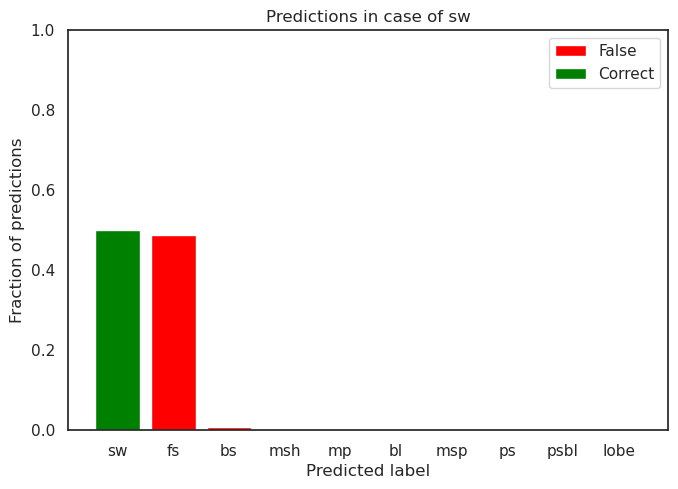

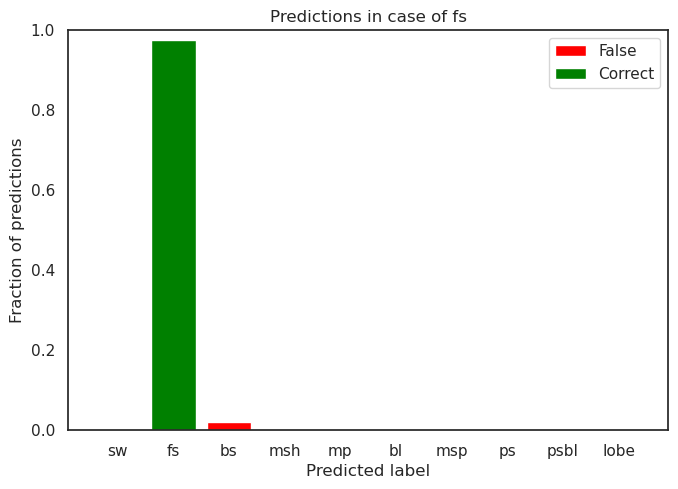

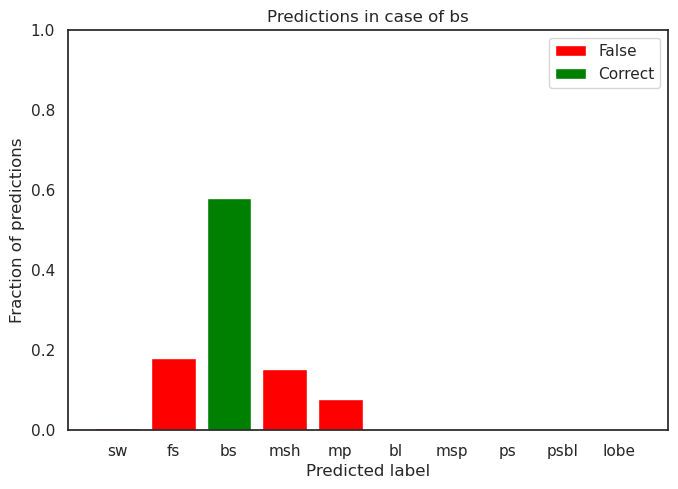

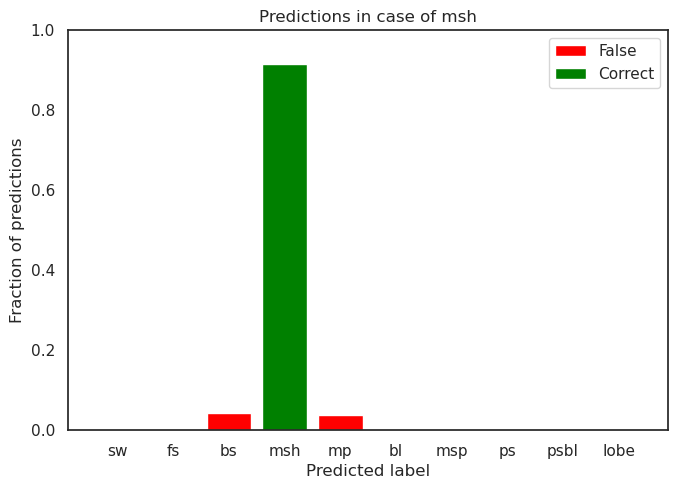

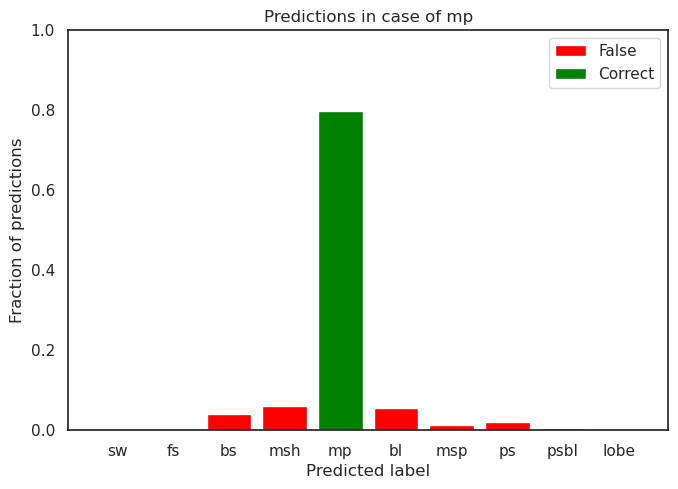

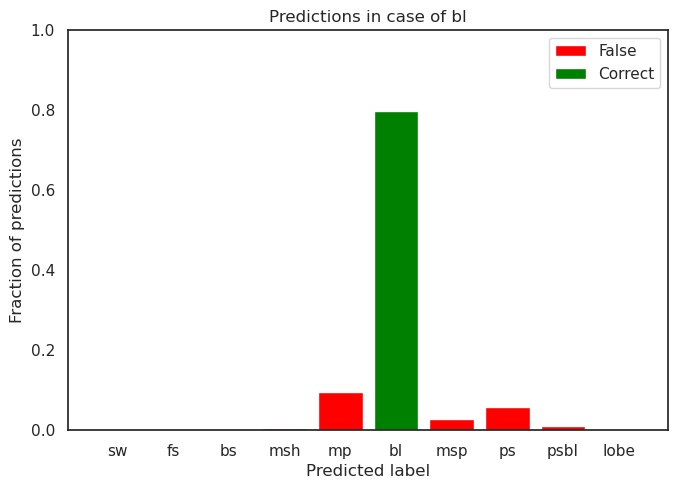

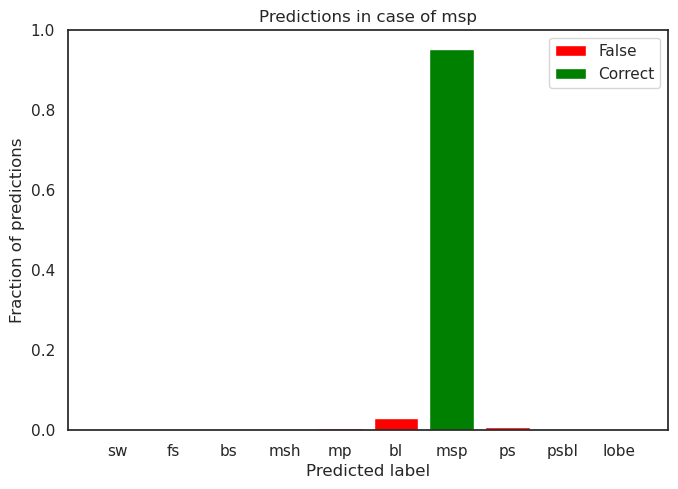

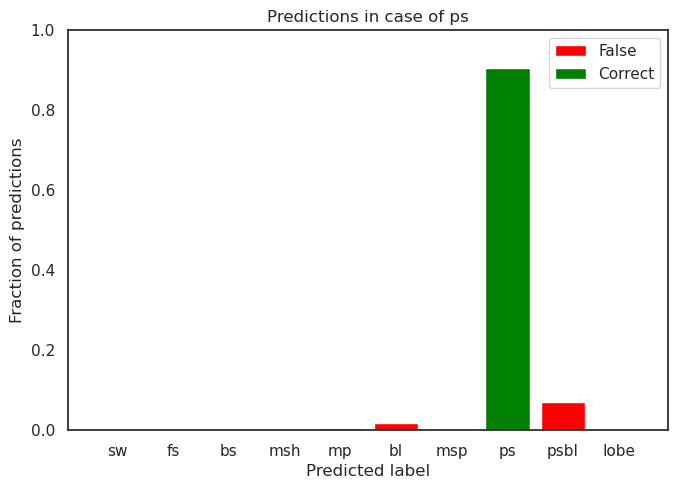

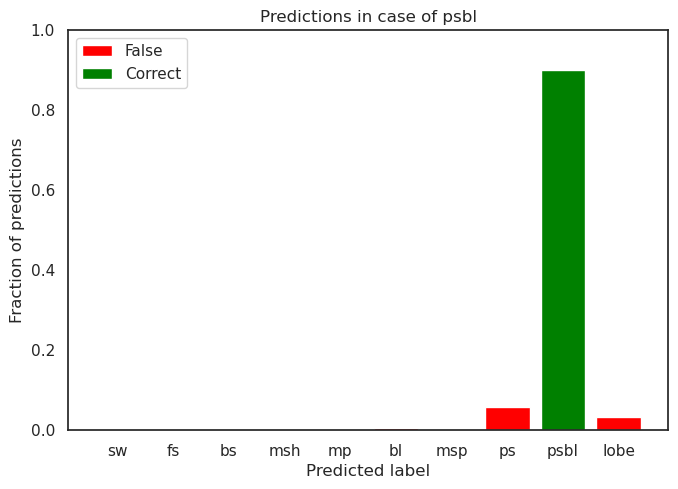

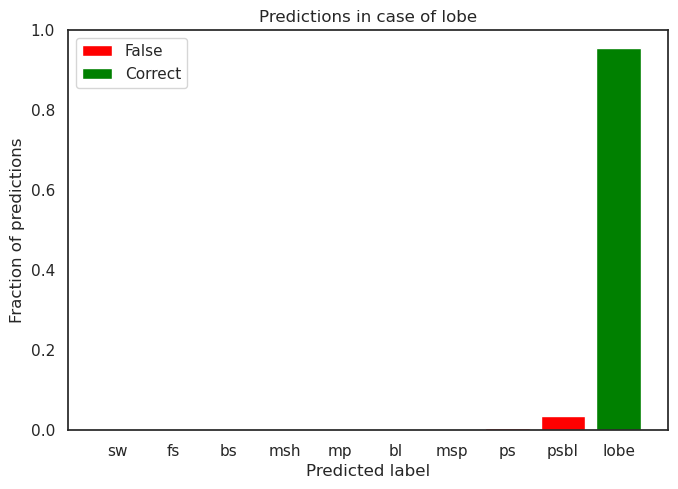

In [123]:
fig_bar=np.zeros(10)
for i in range(0,10):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Predictions in case of '+ association[i])
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Fraction of predictions')
    ax.bar(range(0,10),cf_matrix[i],color='r')
    ax.bar(i,cf_matrix[i][i],color='g')
    ax.legend(['False','Correct'])
    ax.set_xticks(range(0,10,1))
    ax.set_xticklabels(association.values())
    ax.set_ylim((0,1))
    plt.savefig(os.path.join(log_dir,'figures/histograms/hist_'+association[i]+'.eps'),format='eps')

## Display classification report

In [82]:
report = classification_report(y_test, y_pred)
print(report)
with open(os.path.join(log_dir,'figures/class_report.txt'), 'w') as f:
    print(report, file=f) 

              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66     21277
         1.0       0.76      0.97      0.85     47619
         2.0       0.73      0.58      0.65     21156
         3.0       0.87      0.92      0.89     41481
         4.0       0.77      0.80      0.78     33369
         5.0       0.89      0.80      0.84     44303
         6.0       0.96      0.95      0.96     46353
         7.0       0.86      0.90      0.88     35432
         8.0       0.87      0.90      0.88     26645
         9.0       0.94      0.96      0.95     15149

    accuracy                           0.85    332784
   macro avg       0.86      0.83      0.84    332784
weighted avg       0.86      0.85      0.85    332784



## Display ROC curves

n_classes 10


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUC macro average :0.9899722127623914
AUC micro average :0.9913457374166718


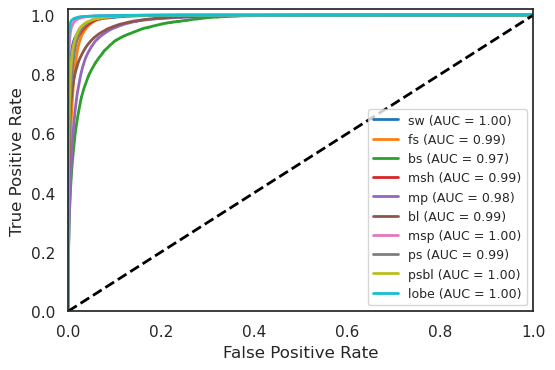

In [78]:
fig_ROC = l_tools.roc_plot(y_score, y_test, association=association)
plt.savefig(os.path.join(log_dir,'figures/ROC.eps'),format='eps')
plt.show()